<a href="https://colab.research.google.com/github/PsorTheDoctor/deep-neural-nets/blob/main/clip_gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CLIP with GradCAM attention visualization

In [127]:
%%capture
!pip install ftfy regex tqdm matplotlib opencv-python scipy scikit-image
!pip install git+https://github.com/openai/CLIP.git

import numpy as np
import torch
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import clip
from PIL import Image
from scipy.ndimage import filters
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from tqdm import tqdm
from torchvision import transforms

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Helper functions

In [5]:
def normalize(x: np.ndarray) -> np.ndarray:
    # Normalize to [0, 1].
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x

# Modified from: https://github.com/salesforce/ALBEF/blob/main/visualization.ipynb
def getAttMap(img, attn_map, blur=True):
    if blur:
        attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap('jet')
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
            (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
    return attn_map

def viz_attn(img, attn_map, blur=True):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.show()

def load_img(img_path, resize=None):
    img = Image.open(img_path).convert("RGB")
    if resize is not None:
        img = img.resize((resize, resize))
    return np.asarray(img).astype(np.float32) / 255.

class Hook:
    """Attaches to a module and records its activations and gradients."""
    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)

    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()

    @property
    def activation(self) -> torch.Tensor:
        return self.data

    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad

##GradCAM: Gradient-weighted Class Activation Mapping

In [3]:
# Reference: https://arxiv.org/abs/1610.02391
def gradCAM(
    model: nn.Module, input: torch.Tensor, target: torch.Tensor, layer: nn.Module
) -> torch.Tensor:
    # Zero out any gradients at the input.
    if input.grad is not None:
        input.grad.data.zero_()

    # Disable gradient settings.
    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)

    # Attach a hook to the model at the desired layer.
    assert isinstance(layer, nn.Module)
    with Hook(layer) as hook:
        # Do a forward and backward pass.
        output = model(input)
        output.backward(target)

        grad = hook.gradient.float()
        act = hook.activation.float()

        # Global average pool gradient across spatial dimension
        # to obtain importance weights.
        alpha = grad.mean(dim=(2, 3), keepdim=True)
        # Weighted combination of activation maps over channel
        # dimension.
        gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
        # We only want neurons with positive influence so we
        # clamp any negative ones.
        gradcam = torch.clamp(gradcam, min=0)

    # Resize gradcam to input resolution.
    gradcam = F.interpolate(
        gradcam, input.shape[2:], mode='bicubic', align_corners=False
    )
    # Restore gradient settings.
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])

    return gradcam

##Load ResNet-based CLIP

In [186]:
clip_model = "RN50"  # "RN50", "RN101", "RN50x4", "RN50x16"
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)

In [185]:
class CeresDataset(Dataset):
  def __init__(self, img_folder, transform=None):
    self.img_folder = Path(img_folder)
    self.img_paths = list(self.img_folder.glob('*.jpg'))
    self.label = clip.tokenize(['ceres logo'])[0]
    self.transform = transform

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img = preprocess(Image.open(self.img_paths[idx]))
    if self.transform:
      img = self.transform(img)

    return img, self.label

In [187]:
transform = transforms.Compose([
    transforms.RandomRotation(degrees=15, interpolation=transforms.InterpolationMode.BILINEAR)
])
dataset = CeresDataset('/content/drive/MyDrive/ceres-logo-images/', transform=transform)

# batch size must be larger than 1
train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

##Fine-tune CLIP

In [188]:
def convert_model_to_fp32(model):
  for p in model.parameters():
    p.data = p.data.float()
    p.grad.data = p.grad.data.float()

opt = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.02)
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

n_epochs = 1
losses = []
for epoch in range(n_epochs):
  pbar = tqdm(train_dataloader, total=len(train_dataloader))
  for batch in pbar:
    opt.zero_grad()

    images, texts = batch
    images = images.to(device)
    texts = texts.to(device)

    logits_per_img, logits_per_txt = model(images, texts)
    ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
    total_loss = (loss_img(logits_per_img, ground_truth) + loss_txt(logits_per_txt, ground_truth)) / 2
    losses.append(float(total_loss))

    total_loss.backward()
    if device == 'cpu':
      opt.step()
    else:
      convert_model_to_fp32(model)
      opt.step()
      clip.model.convert_weights(model)

    pbar.set_description(f'Epoch {epoch}/{n_epochs}, Loss: {total_loss.item():.4f}')

Epoch 0/1, Loss: 0.6948: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


##Visualize attention

<ipython-input-5-205d308ac1a9>:11: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))


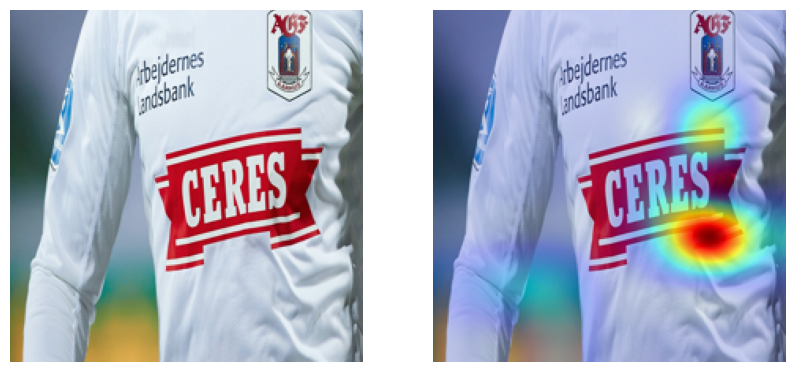

In [196]:
img_path = 'ceres.jpg'
img_caption = 'banner, ceres, logo, caption, title'
saliency_layer = "layer4"  # "layer4", "layer3", "layer2", "layer1"
blur = True

img_input = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
img_np = load_img(img_path, model.visual.input_resolution)
text_input = clip.tokenize([img_caption]).to(device)

attn_map = gradCAM(
    model.visual,
    img_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()
viz_attn(img_np, attn_map, blur)

#Draw bounding boxes

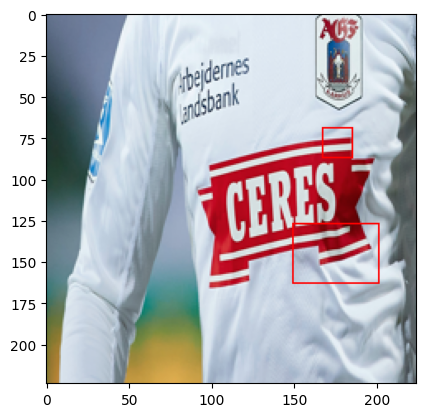

In [197]:
def draw_bounding_boxes(img, attn_map, threshold):
  img_copy = img.copy()
  mask = attn_map / np.max(attn_map)
  mask = cv2.inRange(mask, threshold, 1)
  contours, _ = cv2.findContours(
      mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
  )
  sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
  if sorted_contours:
    for contour in sorted_contours:
      x, y, w, h = cv2.boundingRect(contour)
      cv2.rectangle(img_copy, (x, y), (x+w, y+h), color=(255, 0, 0), thickness=1)
  return img_copy

plt.imshow(draw_bounding_boxes(img_np, attn_map, 0.5))